In [11]:
from neurodiffeq import diff
from neurodiffeq.solvers import Solver1D, Solver2D
from neurodiffeq.conditions import IVP, DirichletBVP2D
from neurodiffeq.networks import FCNN, SinActv, Resnet, Swish, MonomialNN
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp,odeint
import torch
import torch.nn as nn
from neurodiffeq.generators import Generator1D
import math
from neurodiffeq.monitors import Monitor1D
import IPython

In [12]:
alpha0 = 2
alpha1 = 1
C0 = -alpha0/(alpha1)
C1 = 2
C2 = 3
C3 = 4
C4 = 5

Training Progress:   0%|                             | 0/100000 [00:00<?, ?it/s]

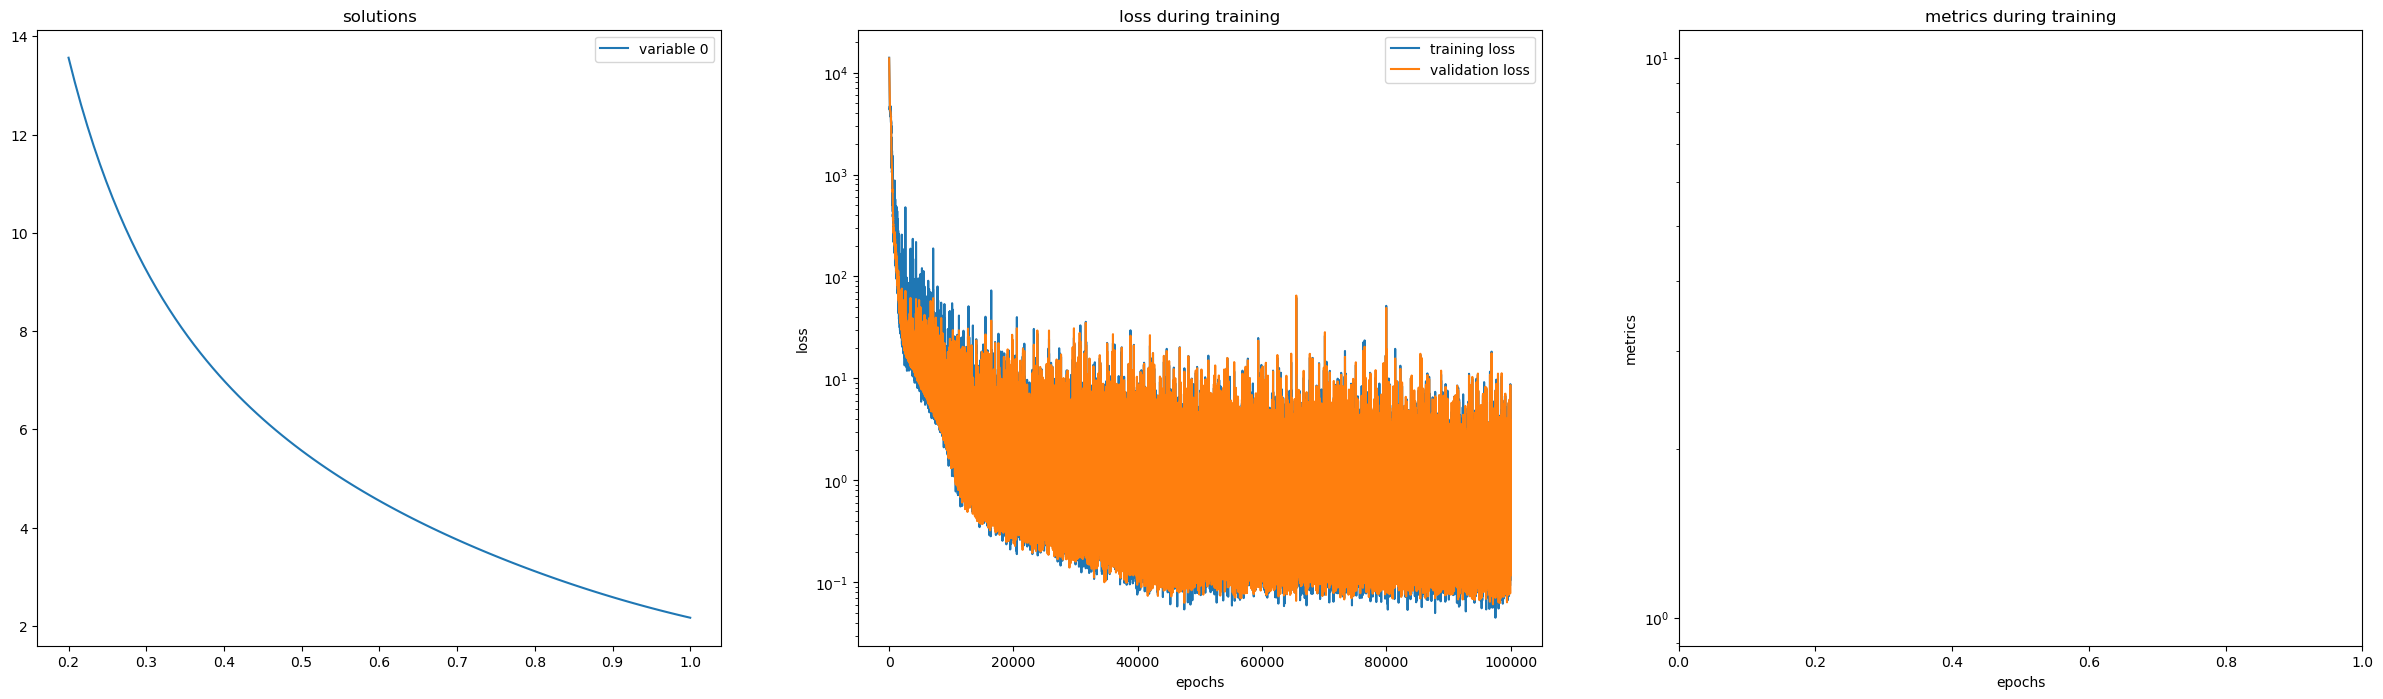

In [13]:
def ode_system(U, t):
    return [(3*torch.pow(t,2)*diff(U,t,order=2) - 6*(U-1))*(t*diff(U,t) + 2*U) + (alpha0/alpha1)*torch.pow(t,2)*(t*diff(U,t) -2*U)]
N = 100000
t_start = 0.2
t_end = 1.0
t = np.linspace(t_start, t_end, N)
U0 = 1 - C0/12 - C1 + C2
U0dash = -C0/6 + C1 - 2*C2

conditions = [IVP(t_0=1.0, u_0=U0, u_0_prime=U0dash)]

nets = [FCNN(actv=SinActv)]

g1 = Generator1D(4096, t_start, t_end, method='uniform')
monitor = Monitor1D(t_min=t_start, t_max=t_end, check_every=N)
# solver = Solver1D(ode_system, conditions, t_min=t_start, t_max=t_end, nets = nets, train_generator=g1, valid_generator=g1)
solver = Solver1D(ode_system, conditions, t_min=t_start, t_max=t_end, nets = nets)
solver.fit(max_epochs=N, callbacks = [monitor.to_callback()])
solution = solver.get_solution()

In [14]:
U_nn = solution(t, to_numpy=True)

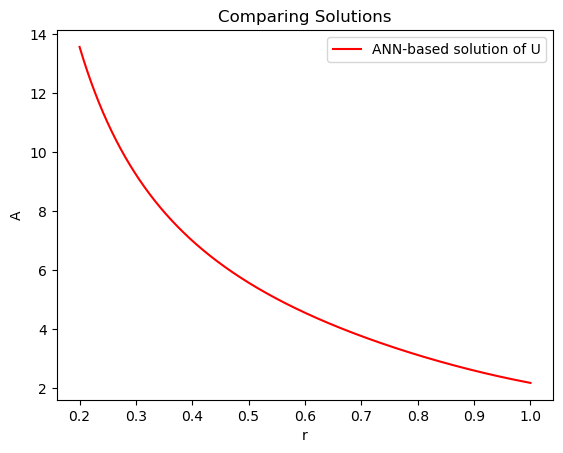

In [15]:
plt.title("Comparing Solutions")
plt.ylabel('A')
plt.xlabel('r')
plt.plot(t, U_nn, label='ANN-based solution of U', color = 'r')
plt.legend()
plt.savefig('lambda')
plt.show()

In [16]:
# Initial conditions
t = np.linspace(t_end, t_start, N)
h = t[1]-t[0]

# Enter the definition of the set of ordinary differential equations
def ode(t,y,u):
  ode_1 = u
  ode_2 = (-alpha0/alpha1)*(t*u-2*y)/(3*(t*u+2*y)) + 2*(y-1)/(t**2)
  return np.array([ode_1,ode_2])

# RK4
y = np.empty(N); u = np.empty(N)

# t[0] = t_initial
y[0] = U0; u[0] = U0dash

for i in range(0,N-1,1):

  k11 = h*ode(t[i],y[i],u[i])[0]
  k12 = h*ode(t[i],y[i],u[i])[1]

  k21 = h*ode(t[i]+(h/2),y[i]+(k11/2),u[i]+(k12/2))[0]
  k22 = h*ode(t[i]+(h/2),y[i]+(k11/2),u[i]+(k12/2))[1]

  k31 = h*ode(t[i]+(h/2),y[i]+(k21/2),u[i]+(k22/2))[0]
  k32 = h*ode(t[i]+(h/2),y[i]+(k21/2),u[i]+(k22/2))[1]

  k41 = h*ode(t[i]+h,y[i]+k31,u[i]+k32)[0]
  k42 = h*ode(t[i]+h,y[i]+k31,u[i]+k32)[1]

  y[i+1] = y[i] + ((k11+2*k21+2*k31+k41)/6)
  u[i+1] = u[i] + ((k12+2*k22+2*k32+k42)/6)
  # t[i+1] = t[i] + h

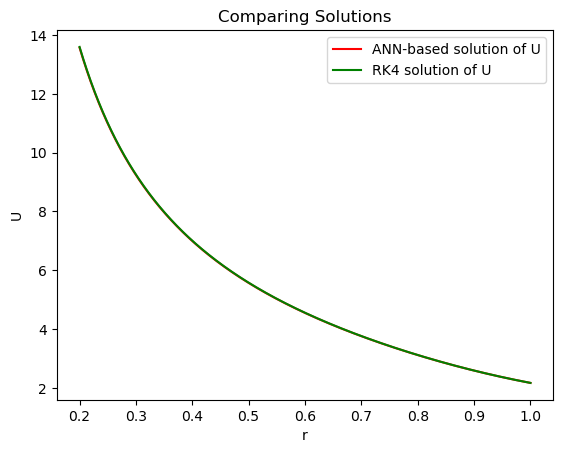

In [23]:
plt.title("Comparing Solutions")
plt.ylabel('U')
plt.xlabel('r')
plt.plot(t[::-1], U_nn, label='ANN-based solution of U', color = 'r')
plt.plot(t, y,label='RK4 solution of U', color = 'g')
plt.legend()
plt.savefig('fR_SR_solution_2_1_U',dpi = 300)
plt.show()

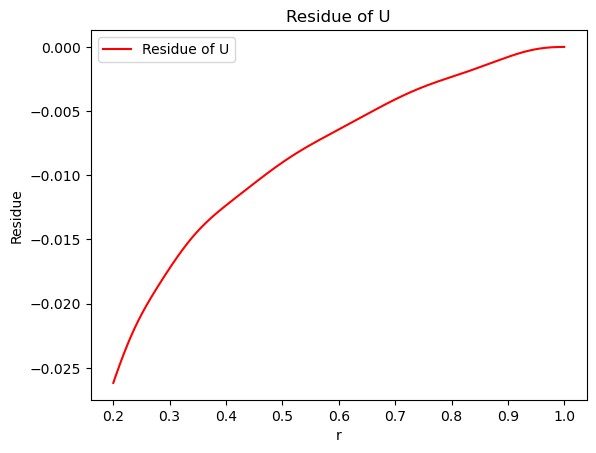

In [24]:
plt.title("Residue of U")
plt.ylabel('Residue')
plt.xlabel('r')
plt.plot(t, U_nn[::-1]-y, label='Residue of U', color = 'r')
plt.legend()
plt.savefig('fR_SR_residue_2_1_U', dpi = 300)
plt.show()

In [19]:
U0

2.166666666666667